## RANK
Before going to a HANK model, we'll solve a basic RANK. This is technically not a part of the McKay series, but is helpful to do before the next step.

#### Preliminaries

In [1]:
# load some packages
import matplotlib.pyplot as plt
import jax.numpy as jnp
import warnings
import jax
jax.config.update('jax_enable_x64', True)  # jax uses 32 bit numbers for some reason

# config
BETA = 0.99
GAMMA = 2
PSI = 5
THETA = 0.75
OMEGA = 1.5
L_BAR = 1
R_BAR = 1/BETA
RHO_Z = 0.8
SIGMA_Z = 0.02
RHO_XI = 0.5
SIGMA_XI = 0.02

#### The Model
**Households** The model is populated by households with preferences given by
$$
    \mathbb{E} \sum_{t=0}^\infty \beta^t \frac{C_t^{1-\gamma}}{1-\gamma}
$$
subject to the budget constraint
$$
    B_t + C_t = R_{t-1} B_{t-1} + W_t \overline{L} + D_t - T_t.
$$

Setting up the Legrangian
$$
    \mathcal{L} = \mathbb{E} \sum_{t=0}^\infty \beta^t \frac{C_t^{1-\gamma}}{1-\gamma} - \lambda_t\left(R_{t-1} B_{t-1} + W_t \overline{L} + D_t - T_t - B_t - C_t\right)
$$
gets the FOCs
\begin{align*}
    \lambda_t = C_t^{-\gamma} \\
    \lambda_t = \beta R_t \lambda_{t+1}
\end{align*}
which gets the Euler Equation
$$
    C_t^{-\gamma} = \beta R_t C_{t+1}^{-\gamma}.
$$

**Final Goods Firms** There is a single, representative final goods firm which aggregates intermediate goods and sells them to households. The aggregator is given by
$$
    Y_t = \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{\psi}{\psi - 1}.
$$
The firm profit maximization problem
$$
    \max_{y_{j, t}} P_t Y_t - \int_0^1 p_{j, t} y_{j, t} dj
$$
becomes
$$
    \max_{y_{j, t}} P_t \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{\psi}{\psi - 1} - \int_0^1 p_{j, t} y_{j, t} dj
$$
which has the FOC
$$
    p_{j, t} = P_t \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{1}{\psi - 1} y_{j, t}^\frac{-1}{\psi}
$$
which gets the intermediate good demand function
$$
    y_{j, t} = Y_t \left(\frac{P_t}{p_{j, t}}\right)^\psi
$$
and, plugging this into the aggregator, the price aggregation function
$$
    P_t = \left(\int_0^1 p_{j, t}^{1-\psi}dj\right)^\frac{1}{1-\psi}.
$$

**Intermediate Goods Firms** The model is populated by a unit continuum of monopolistically competitive intermediate goods firms $j \in [0, 1]$. Each intermediate goods firm produces their variety according to the production function
$$
    y_{j, t} = Z_t n_{j, t}.
$$
The cost minimization problem
\begin{align*}
    \min_{n_{j, t}}\quad& W_t n_{j, t} \\
    \text{subject to}\quad& y_{j, t} = Z_t n_{j, t}
\end{align*}
has the Lagrangian
$$
    \mathcal{L} = W_t n_{j, t} + \lambda_{j, t} \left(y_{j, t} - Z_t n_{j, t}\right)
$$
which has the FOC
$$
    W_t = Z_t \lambda_{j, t}
$$
which, since $W_t$ and $Z_t$ are equal for all firms means we can define $\lambda_{j, t} = \Lambda_t$ so
$$
    W_t = Z_t \Lambda_t.
$$
Each period, intermediate goods firms follow a Calvo pricing rule to update prices with probability $1-\theta$. When updating their price, firms pick $P_t^*$ to maximize expected profits now until they get to update their price again later, meaning they solve
\begin{align*}
    \max{P_t^*} \quad& \mathbb{E} \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} \left(\frac{P_t^*}{P_s} y_{j, t} - W_s n_{j, s}\right) \\
    \text{subject to} \quad& W_s = Z_s \lambda_s \\
    & Z_s n_{j, s} = y_{j, s} \\
    & y_{j, s} = Y_s \left(\frac{P_s}{P_t^*}\right)^\psi
\end{align*}
which becomes
$$
    \max_{P_t^*} \mathbb{E} \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} \left(Y_s \left(\frac{P_s}{P_t^*}\right)^{\psi-1} - \Lambda_s Y_s \left(\frac{P_s}{P_t^*}\right)^\psi\right).
$$
This has the FOC
$$
    \frac{P_t^*}{P_t} = \frac{\psi \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s \left(\frac{P_s}{P_t^*}\right)^{\psi-1}}{(\psi-1) \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s \left(\frac{P_s}{P_t^*}\right)^\psi}.
$$
To make this a tractable problem, we'll define
\begin{align*}
    P_t^A = \frac{\psi}{\psi-1} \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s \left(\frac{P_s}{P_t^*}\right)^{\psi-1} = \frac{\psi}{\psi-1} \Lambda_t Y_t + \theta R_t^{-1} \pi_{t+1}^\psi P_{t+1}^A \\
    P_t^B = \frac{\psi}{\psi-1} \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s \left(\frac{P_s}{P_t^*}\right)^{\psi-1} = Y_t + \theta R_t^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^B \\
\end{align*}
so that
$$
\frac{P_t^*}{P_t} = \frac{P_t^A}{P_t^B}.
$$

Finally, we'll let the firms pay out a divdend to households such that
$$
    d_{i, j} = y_{i, j} p_{i, j} - P_t W_t n_{i, j}.
$$

**Firms Aggregated** Based on the Calvo Rule, each period $\theta$ of the firms keep their price and $1-\theta$ change it. Therefore, we know
$$
    P_t = \left(\int_0^1 p_{j, t}^{1-\psi}dj\right)^\frac{1}{1-\psi} = \left(\theta \int_0^1 p_{j, t-1}^{1-\psi}dj + (1-\theta) \int_0^1 P_t^{* 1-\psi}dj\right)^\frac{1}{1-\psi} = \left(\theta P_{t-1}^{1-\psi} + (1-\theta) P_t^{* 1-\psi}\right)^\frac{1}{1-\psi}
$$
Dividing out $P_t$ gets
$$
    1 = \left(\theta \left(\frac{P_{t-1}}{P_t}\right)^{1-\psi} + (1-\theta) \left(\frac{P_t^*}{P_t}\right)^{1-\psi}\right)^\frac{1}{1-\psi} = \theta \pi_t^{\psi-1} + (1-\theta) \left(\frac{P_t^*}{P_t}\right)^{1-\psi}.
$$
Defining
$$
    \overline{L} = \int_0^1 n_{j, t} dj
$$
means the production function becomes
$$
    Y_t = Z_t \overline{L}
$$
under a first-order-approximation and the dividend expression becomes
$$
    D_t = Y_t - W_t N_t
$$

**Government** The only role of the government is to tax households to finance debt such that
$$
    T_t + B_t = R_{t-1} B_{t-1}.
$$

**Central Bank** The central bank sets the interest rate according to the Taylor Rule
$$
    I_t = \overline{R} \pi_t^\omega \xi_t
$$
where $I_t$ follows
$$
    R_t = \frac{I_t}{\pi_{t+1}}
$$

**Exogenous Processes** $Z_t$ follows the exogenous process
$$
    \log Z_t = \rho_Z \log Z_{t-1} + \varepsilon_Z
$$
and $\xi_t$ follows the exogenous process
$$
    \log \xi_t = \rho_\xi \log \xi_t + \varepsilon_\xi
$$
where $\varepsilon_Z \sim \mathcal{N} (0, \sigma_Z)$ and $\varepsilon_\xi \sim \mathcal{N} (0, \sigma_\xi)$.

The variables in the model represent
| Variable | Meaning |
| --- | --- |
| $C_t$ | Consumption at time $t$ |
| $B_t$ | Bond holdings at time $t$ |
| $R_t$ | Real interest rate at time $t$ |
| $W_t$ | Wage rate at time $t$ |
| $D_t$ | The dividends at time $t$ |
| $T_t$ | The lump sum taxes at time $t$ |
| $Y_t$ | Aggregate output at time $t$ |
| $\Lambda_t$ | Marginal cost at time $t$ |
| $\pi_t$ | Inflation at time $t$ |
| $I_t$ | Nominal interest rate at time $t$ |
| $Z_t$ | Productivity multiplier at time $t$ |
| $\xi_t$ | Monetary policy shock at time $t$ |

and the parameters in the model represent
| Parameter | Meaning |
| --- | --- |
| $\beta$ | Intertemporal discount factor |
| $\gamma$ | Risk aversion parameter |
| $\psi$ | Aggregation parameter |
| $\omega$ | Power of inflation in setting the interest rate |
| $\theta$ | Percentage of firms that update their price each period |
| $\overline{L}$ | Fixed labor supply |
| $\overline{R}$ | Goal interest rate |
| $\rho_Z$ | Regression to mean (1) of aggregate production |
| $\sigma_Z$ | Standard deviation of $Z$ shocks |
| $\rho_\xi$ | Regression to mean (1) of monetary policy shocks |
| $\sigma_\xi$ | Standard deviation of $\xi$ shocks |

The overall system we solve is
\begin{align*}
    Y_t^{-\gamma} &= \beta R_t Y_{t+1}^{-\gamma} \\
    P_t^A &= \frac{\psi}{\psi-1} \Lambda_t Y_t + \theta R_t^{-1} \pi_{t+1}^\psi P_{t+1}^A \\
    P_t^B &= Y_t + \theta R_t^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^B \\
    1 &= \theta \pi_t^{\psi-1} + (1-\theta) \left(\frac{P_t^A}{P_t^B}\right)^{1-\psi} \\
    Y_t &= Z_t \overline{L} \\
    W_t &= Z_t \Lambda_t \\
    I_t &= \overline{R} \pi_t^\omega \xi_t \\
    R_t &= \frac{I_t}{\pi_{t+1}} \\
    \log Z_t &= \rho_Z \log Z_{t-1} + \varepsilon_Z \\
    \log \xi_t &= \rho_\xi \log \xi_t + \varepsilon_\xi.
\end{align*}
We ignore the dividend expression, government budget, and household budget single they're fully collinear and plug in $\frac{P_t^A}{P_t^B}$ for $\frac{P_t^*}{P_t}$ and plug in the market clearing condition $Y_t = C_t$.

#### Setup the Model
Similar to how we solve the RBC model, we'll setup a residual function and create a matrix equation.

In [10]:
# residual
def residual(X_l, X_t, X_p, err):
    # extract values
    Y_l, W_l, Lambda_l, R_l, I_l, PA_l, PB_l, Pi_l, Z_l, Xi_l = X_l
    Y_t, W_t, Lambda_t, R_t, I_t, PA_t, PB_t, Pi_t, Z_t, Xi_t = X_t
    Y_p, W_p, Lambda_p, R_p, I_p, PA_p, PB_p, Pi_p, Z_p, Xi_p = X_p
    err_Z, err_xi = err

    return jnp.array([
            Y_t**(-GAMMA) - BETA * R_t * Y_p**(-GAMMA),  # euler equation
            PA_t - PSI/(PSI-1) * Lambda_t * Y_t - THETA * R_t**(-1) * Pi_p**PSI * PA_p, # PA def
            PB_t - Y_t - THETA * R_t**(-1) * Pi_p**(PSI-1) * PB_p, # PB def
            1 - THETA * Pi_t**(PSI-1) - (1-THETA) * (PA_t / PB_t)**(1-PSI),  # calvo rule
            Y_t - Z_t * L_BAR,  # production function
            W_t - Z_t * Lambda_t,  # marginal cost def
            I_t - R_BAR * Pi_t**OMEGA * Xi_t,  # taylor rule
            R_t - I_t/Pi_p,  # real rate def
            RHO_Z * jnp.log(Z_l) + err_Z - jnp.log(Z_t),  # agregate productivity law of motion
            RHO_XI * jnp.log(Xi_l) + err_xi - jnp.log(Xi_t),  # monetary shock law of motion
        ])

# get steady state
Pi = Z = Xi = 1
I = R = R_BAR
Y = L_BAR
Lambda = W = (PSI-1) / PSI
PA = PB = L_BAR / (1 - THETA * R_BAR**(-1))
X_ss = jnp.array([Y, W, Lambda, R, I, PA, PB, Pi, Z, Xi])
err_ss = jnp.zeros(2)
assert jnp.allclose(residual(X_ss, X_ss, X_ss, err_ss), 0)  # check the ss

# get matricies
A = jax.jacfwd(lambda X_l: residual(X_l, X_ss, X_ss, err_ss))(X_ss)
B = jax.jacfwd(lambda X: residual(X_ss, X, X_ss, err_ss))(X_ss)
C = jax.jacfwd(lambda X_p: residual(X_ss, X_ss, X_p, err_ss))(X_ss)
E = jax.jacfwd(lambda err: residual(X_ss, X_ss, X_ss, err))(err_ss)

#### Linear Time Iteration
Use Linear Time Iteration to solve the problem for a policy rule.

In [11]:
def linear_time_iteration(A, B, C, E, max_iter=1000, tol=1e-7):
    '''
    Implentation of Linear Time Iteration from Rendahl (2017) to find
    a policy rule for a dynamic system. 

    Note: This doesn't check BK solutions, so it can output invalid
    policy rules.
    '''
    # intial guess
    P = jnp.zeros_like(A)  # intial guess is all zeros

    # run incremental update algorithms
    for _ in range(max_iter):
        # update rule
        P = -jnp.linalg.inv(B + C@P) @ A

        # exit condition
        diff = jnp.abs(A + B@P + C@P@P).max()
        if diff < tol:
            break
    else:
        warnings.warn('Max iteration count exceeded')

    # get error matrix
    Q = -jnp.linalg.inv(B + C@P) @ E  # @E at the end keeps only releveant columns 

    return P, Q

P, Q = linear_time_iteration(A, B, C, E)

#### Impulse Response
Use our policy rule to simulate the response to two shocks.

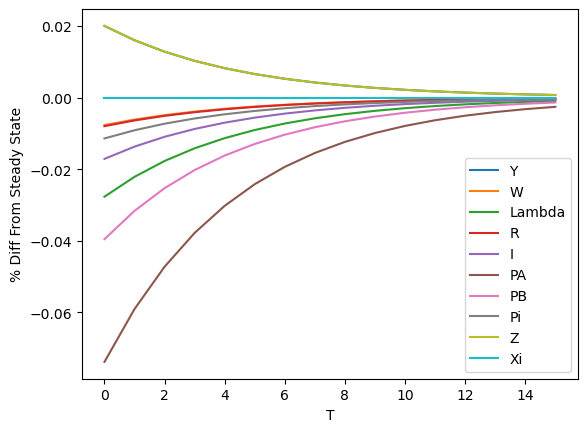

In [19]:
## Output shock
# config
T = 15
res = jnp.zeros((T+1, X_ss.shape[0]))

# simplate it
res = res.at[0, :].set((Q @ jnp.array([SIGMA_Z, 0])).ravel())
for t in range(1, T+1):
    res = res.at[t, :].set(P @ res[t-1, :])

# plot it
plt.xlabel('T')
plt.ylabel('% Diff From Steady State')
plt.plot(jnp.arange(T+1), res / X_ss, label=['Y', 'W', 'Lambda', 'R', 'I', 'PA', 'PB', 'Pi', 'Z', 'Xi'])
plt.legend()

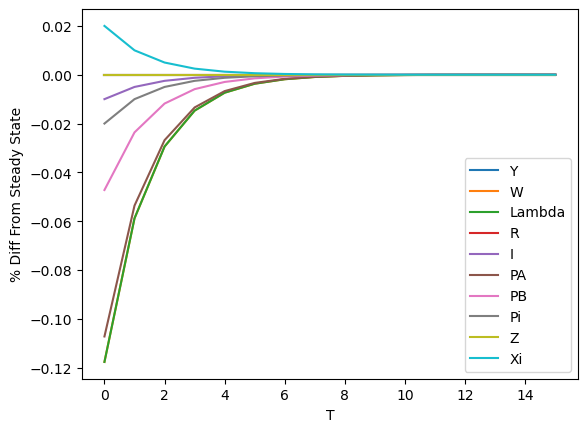

In [20]:
## monetary shock
# config
T = 15
res = jnp.zeros((T+1, X_ss.shape[0]))

# simplate it
res = res.at[0, :].set((Q @ jnp.array([0, SIGMA_XI])).ravel())
for t in range(1, T+1):
    res = res.at[t, :].set(P @ res[t-1, :])

# plot it
plt.xlabel('T')
plt.ylabel('% Diff From Steady State')
plt.plot(jnp.arange(T+1), res / X_ss, label=['Y', 'W', 'Lambda', 'R', 'I', 'PA', 'PB', 'Pi', 'Z', 'Xi'])
plt.legend()